In [1]:
# Import required libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import random

#Transfer Learning with TensorFlow Part 3: Scaling up (🍔 Food Vision mini)

In [2]:
## Creating helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-23 04:06:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-23 04:06:29 (95.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import the functions needed
from helper_functions import create_tensorboard_callback, plot_loss_curves, pred_and_plot, unzip_data, walk_through_dir, compare_historys, confusion_matrix

# 101 Food Classes: Working with less data

We could start modelling straight away on this large dataset but in the spirit of continually experimenting, we're going to see how our previously working model's go with 10% of the training data.

This means for each of the 101 food classes we'll be building a model on 75 training images and evaluating it on 250 test images.

# Downloading and preprocessing the data

In [4]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-01-23 04:06:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.103.207, 108.177.120.207, 142.250.159.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.103.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   114MB/s    in 13s     

2024-01-23 04:06:43 (118 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# walkthrough the data
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/red_velvet_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tiramisu'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spaghetti_bolognese'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_mousse'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pulled_pork_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/miso_soup'.
There are 0 

In [6]:
# prompt: generate a function which accepts the test or train as input and will display one of the images from these randomly

def show_random_image(dir):
  """Displays a random image from the given directory."""
  # Get a random image path
  target_dir = "101_food_classes_10_percent"

  # Store the class names
  class_names = []
  for subdir in os.listdir(train_dir):
    class_names.append(subdir)
  #print(class_names)

  target_class = random.choice(class_names)
  path = target_dir + "/" + dir + "/" +target_class
  image_path = random.choice(os.listdir(path))
  print(image_path)

  # Read the image
  image = mpimg.imread(os.path.join(path, image_path))

  # Display the image
  plt.imshow(image)
  plt.title(target_class)
  plt.axis(False)
  plt.show()


3656540.jpg


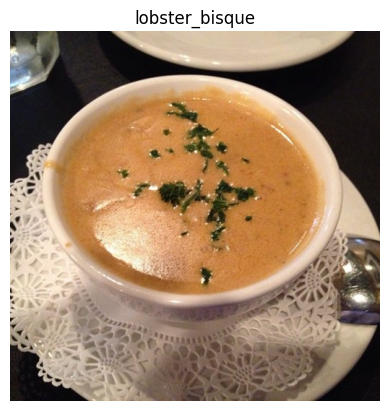

In [7]:
show_random_image("train")

In [8]:
## Setup data inputs
IMG_SIZE = (224, 224)

# Data loader
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                image_size = IMG_SIZE,
                                                                                label_mode = "categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Train a big dog model with transfer learning on 10% of 101 food classes
- A ModelCheckpoint callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time
- Data augmentation built right into the model
- A headless (no top layers) EfficientNetB0 architecture from tf.keras.applications as our base model
- A Dense layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer
- Categorical crossentropy as the loss function since we're dealing with more than two classes
- The Adam optimizer with the default settings
- Fitting for 5 full passes on the training data while evaluating on 15% of the test data

In [9]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint/checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_best_only = True,
                                                         monitor = "val_accuracy",
                                                         save_weights_only = True)


In [10]:
# Create the augmentations
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
    #layers.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
])

In [11]:
# Setup the base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
base_model.trainable = False

# Set up the model architecture with trainable top layer
inputs = layers.Input(shape = (224, 224, 3), name = "input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_2d")(x)
outputs = layers.Dense(101, activation="softmax", name = "output_layer")(x)
model_1 = keras.Model(inputs, outputs)


24274472/24274472 [==============================] - 0s 0us/step


In [12]:
# Get a summary of our model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_2d   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 6048693 (23.07 MB)
Trainable params: 129381 (50

In [13]:
# Compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# fit the model
history_all_classes_10_percent = model_1.fit(train_data_all_10_percent,
                                             validation_data = test_data,
                                             validation_steps = int(0.15 * len(test_data)),
                                             epochs = 5,
                                             callbacks = [checkpoint_callback])


Epoch 1/5
237/237 [==============================] - 213s 846ms/step - loss: 3.4953 - accuracy: 0.2442 - val_loss: 2.6489 - val_accuracy: 0.4123
Epoch 2/5
237/237 [==============================] - 131s 549ms/step - loss: 2.3792 - accuracy: 0.4562 - val_loss: 2.1225 - val_accuracy: 0.4815
Epoch 3/5
237/237 [==============================] - 116s 487ms/step - loss: 2.0110 - accuracy: 0.5262 - val_loss: 1.9623 - val_accuracy: 0.5061
Epoch 4/5
237/237 [==============================] - 95s 397ms/step - loss: 1.7934 - accuracy: 0.5667 - val_loss: 1.8483 - val_accuracy: 0.5281
Epoch 5/5
237/237 [==============================] - 85s 359ms/step - loss: 1.6298 - accuracy: 0.5949 - val_loss: 1.8264 - val_accuracy: 0.5236


In [14]:
# Evaluate model
results_feature_extraction_model = model_1.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 58s 74ms/step - loss: 1.6316 - accuracy: 0.5650


[1.6316134929656982, 0.5650296807289124]

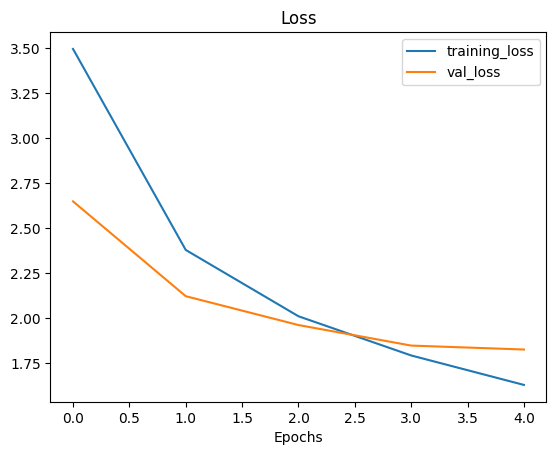

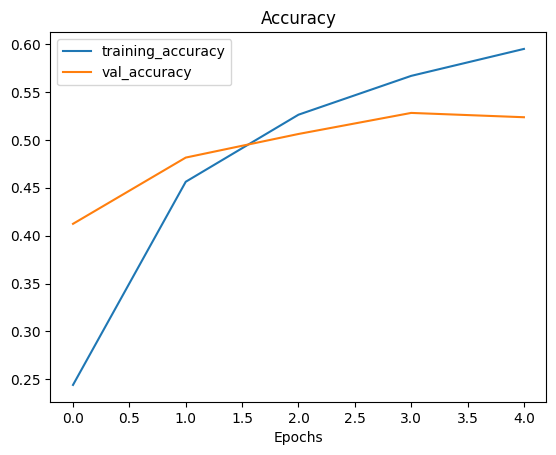

In [15]:
plot_loss_curves(history_all_classes_10_percent)

# Fine-tuning

In [16]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze all layers except last 5 layers
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [17]:
# Recompile model
model_1.compile(loss = "categorical_crossentropy",
            optimizer = tf.keras.optimizers.Adam(0.0001),
            metrics = ['accuracy'])

# Fine tune for 5 more epochs
fine_tune_epochs = 10

# Fit the model
history_all_classes_10_percent_fine_tune = model_1.fit(train_data_all_10_percent,
                                                       validation_data = test_data,
                                                       validation_steps = int(0.15 * len(test_data)),
                                                       epochs = fine_tune_epochs,
                                                       initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 90s 336ms/step - loss: 1.4376 - accuracy: 0.6385 - val_loss: 1.7598 - val_accuracy: 0.5344
Epoch 6/10
237/237 [==============================] - 75s 314ms/step - loss: 1.3549 - accuracy: 0.6479 - val_loss: 1.7307 - val_accuracy: 0.5426
Epoch 7/10
237/237 [==============================] - 62s 261ms/step - loss: 1.2879 - accuracy: 0.6638 - val_loss: 1.7447 - val_accuracy: 0.5365
Epoch 8/10
237/237 [==============================] - 64s 267ms/step - loss: 1.2467 - accuracy: 0.6705 - val_loss: 1.7593 - val_accuracy: 0.5347
Epoch 9/10
237/237 [==============================] - 55s 230ms/step - loss: 1.2158 - accuracy: 0.6783 - val_loss: 1.7251 - val_accuracy: 0.5405
Epoch 10/10
237/237 [==============================] - 58s 242ms/step - loss: 1.1657 - accuracy: 0.6899 - val_loss: 1.7391 - val_accuracy: 0.5448


In [18]:
# evaluate model
results_all_classes_10_percent_fine_tune = model_1.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 55s 70ms/step - loss: 1.4970 - accuracy: 0.5971


[1.497019648551941, 0.5971485376358032]

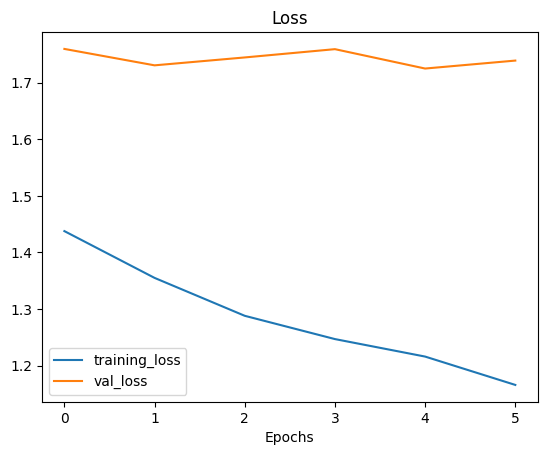

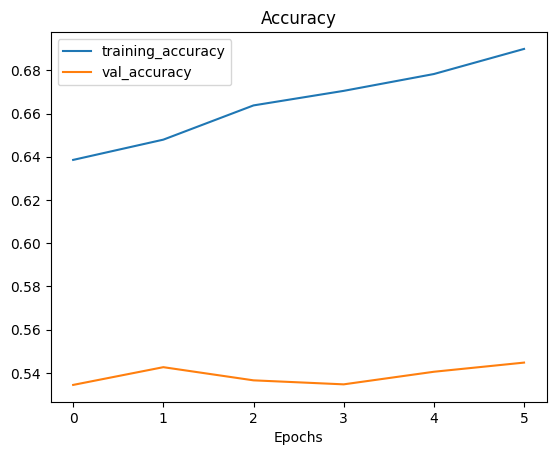

In [19]:
# Plot the curves
plot_loss_curves(history_all_classes_10_percent_fine_tune)

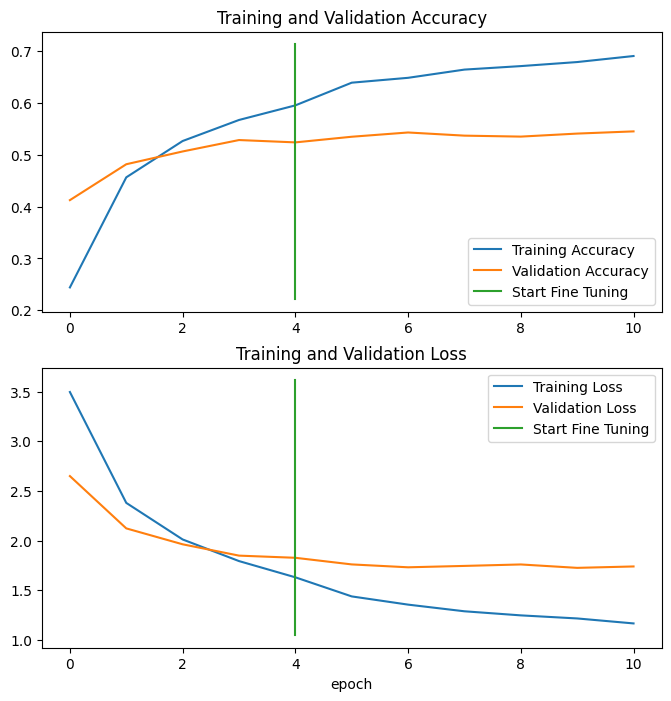

In [20]:
# Compare
compare_historys(history_all_classes_10_percent, history_all_classes_10_percent_fine_tune,initial_epochs=5)

# Saving Model

In [21]:
# save our fine tuned model
model_1.save("/content/drive/MyDrive/Colab Notebooks/SavedModels/01_food_class_10_percent_saved_big_dog_model")

In [22]:
# Load and evaluate model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/SavedModels/01_food_class_10_percent_saved_big_dog_model")

In [23]:
# Evaludate model and compare performance to previous model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 59s 73ms/step - loss: 1.4970 - accuracy: 0.5971


[1.497019648551941, 0.5971485376358032]

In [24]:
# The results from loaded model should be very similary
results_all_classes_10_percent_fine_tune

[1.497019648551941, 0.5971485376358032]

# Evaluting performance of big dog model across all different classes

In [25]:
# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

# Note: loading a model will output a lot of 'WARNINGS', these can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
# model = tf.keras.models.load_model("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/") # path to drive model
model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path

--2024-01-23 04:29:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.207, 74.125.69.207, 64.233.181.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  43.7MB/s    in 1.0s    

2024-01-23 04:29:39 (43.7 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [26]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 66s 80ms/step - loss: 1.8027 - accuracy: 0.6078


(1.8027204275131226, 0.6077623963356018)

In [27]:
# Making predictions with our model
preds_prob = model.predict(test_data, verbose=1) # set verbosity to see how long it will take

790/790 [==============================] - 64s 79ms/step


In [28]:
len(preds_prob)

25250

In [29]:
# Whats the shape of predictions
preds_prob.shape

(25250, 101)

In [30]:
# How do they look?
preds_prob[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [31]:
preds_prob[0]

array([5.95422499e-02, 3.57421641e-06, 4.13771868e-02, 1.06605680e-09,
       8.16142265e-09, 8.66399219e-09, 8.09274582e-07, 8.56526867e-07,
       1.98591733e-05, 8.09777873e-07, 3.17277227e-09, 9.86742407e-07,
       2.85322807e-04, 7.80494447e-10, 7.42302567e-04, 3.89163870e-05,
       6.47404477e-06, 2.49773825e-06, 3.78912555e-05, 2.06783156e-07,
       1.55384569e-05, 8.15072838e-07, 2.62307503e-06, 2.00107493e-07,
       8.38279675e-07, 5.42160024e-06, 3.73910780e-06, 1.31505740e-08,
       2.77615967e-03, 2.80519544e-05, 6.85622448e-10, 2.55749364e-05,
       1.66889979e-04, 7.64073860e-10, 4.04531223e-04, 1.31507001e-08,
       1.79573817e-06, 1.44482760e-06, 2.30628420e-02, 8.24669542e-07,
       8.53656331e-07, 1.71387171e-06, 7.05256616e-06, 1.84021545e-08,
       2.85534099e-07, 7.94837069e-06, 2.06816003e-06, 1.85251395e-07,
       3.36199406e-08, 3.15226236e-04, 1.04109558e-05, 8.54483915e-07,
       8.47418129e-01, 1.05554591e-05, 4.40948469e-07, 3.74041920e-05,
      

In [32]:
# We get one prediction probability per class, here 101 class probs
print(f"Number of prediction probs for sample 0 : {len(preds_prob[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_prob[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_prob[0].argmax()}")


Number of prediction probs for sample 0 : 101
What prediction probability sample 0 looks like:
 [5.95422499e-02 3.57421641e-06 4.13771868e-02 1.06605680e-09
 8.16142265e-09 8.66399219e-09 8.09274582e-07 8.56526867e-07
 1.98591733e-05 8.09777873e-07 3.17277227e-09 9.86742407e-07
 2.85322807e-04 7.80494447e-10 7.42302567e-04 3.89163870e-05
 6.47404477e-06 2.49773825e-06 3.78912555e-05 2.06783156e-07
 1.55384569e-05 8.15072838e-07 2.62307503e-06 2.00107493e-07
 8.38279675e-07 5.42160024e-06 3.73910780e-06 1.31505740e-08
 2.77615967e-03 2.80519544e-05 6.85622448e-10 2.55749364e-05
 1.66889979e-04 7.64073860e-10 4.04531223e-04 1.31507001e-08
 1.79573817e-06 1.44482760e-06 2.30628420e-02 8.24669542e-07
 8.53656331e-07 1.71387171e-06 7.05256616e-06 1.84021545e-08
 2.85534099e-07 7.94837069e-06 2.06816003e-06 1.85251395e-07
 3.36199406e-08 3.15226236e-04 1.04109558e-05 8.54483915e-07
 8.47418129e-01 1.05554591e-05 4.40948469e-07 3.74041920e-05
 3.53062715e-05 3.24890498e-05 6.73150862e-05 1.28

In [33]:
# Get the pred classes for each label
pred_classes = preds_prob.argmax(axis = 1)

# how do they look now
pred_classes

array([ 52,   0,   0, ..., 100,  94, 100])

In [34]:
# how many
len(pred_classes)

25250

In [35]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Evaluating models predictions


In [36]:
# Lets try sklearn accuracy score
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels, y_pred = pred_classes)

In [37]:
sklearn_accuracy

0.6077623762376237

In [38]:
# Does the evaluate method compare to the Scikit-Learn measured accuracy?
import numpy as np
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")

Close? True | Difference: 2.0097978059574473e-08


# Confusion Matrix

In [39]:
from helper_functions import make_confusion_matrix

In [40]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [41]:
# Get the class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [42]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_labels,
                      y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

Precision:  
Out of all the positive predicted values, how many are truly positive or correctly classified  
The ability of a classification model to identify only the relevant data points.  

Formula : (TP) / (TP + FP)


Recall:  
Out of all the positive values from the data, how many are truly classified as positive  
The ability of a model to find all the relevant cases within a data set.   

Formula : (TP) / (TP + FN)

For a dataset classifying diseases,
If we are saying we have 75% precision, then out of all the predicted values, we are correctly classifying 75% positive values.

For the same,
if we are saying, we have 60% recall, then we are classifying only 60% positive values as positive and losing out on 40% remaining positive values.

Hence there is a tradeoff between Precision and Recall which we need to maintain inorder to get the best model.

There is ROC Curve which we can use inorder to check for the Precision, Recall value tradeoff using the threshold value.

We can check for the area under the curve for TPR (Recall) and FPR(False Prediction Rate) which can be used to optimize the classifier.

When we increase the threshold, we are getting the TP values but at the same time we are getting more FP values.  Hence we need to chose a threshold which gives maximum TP values but at the same time minimum FP values.

In [45]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [46]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [47]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008

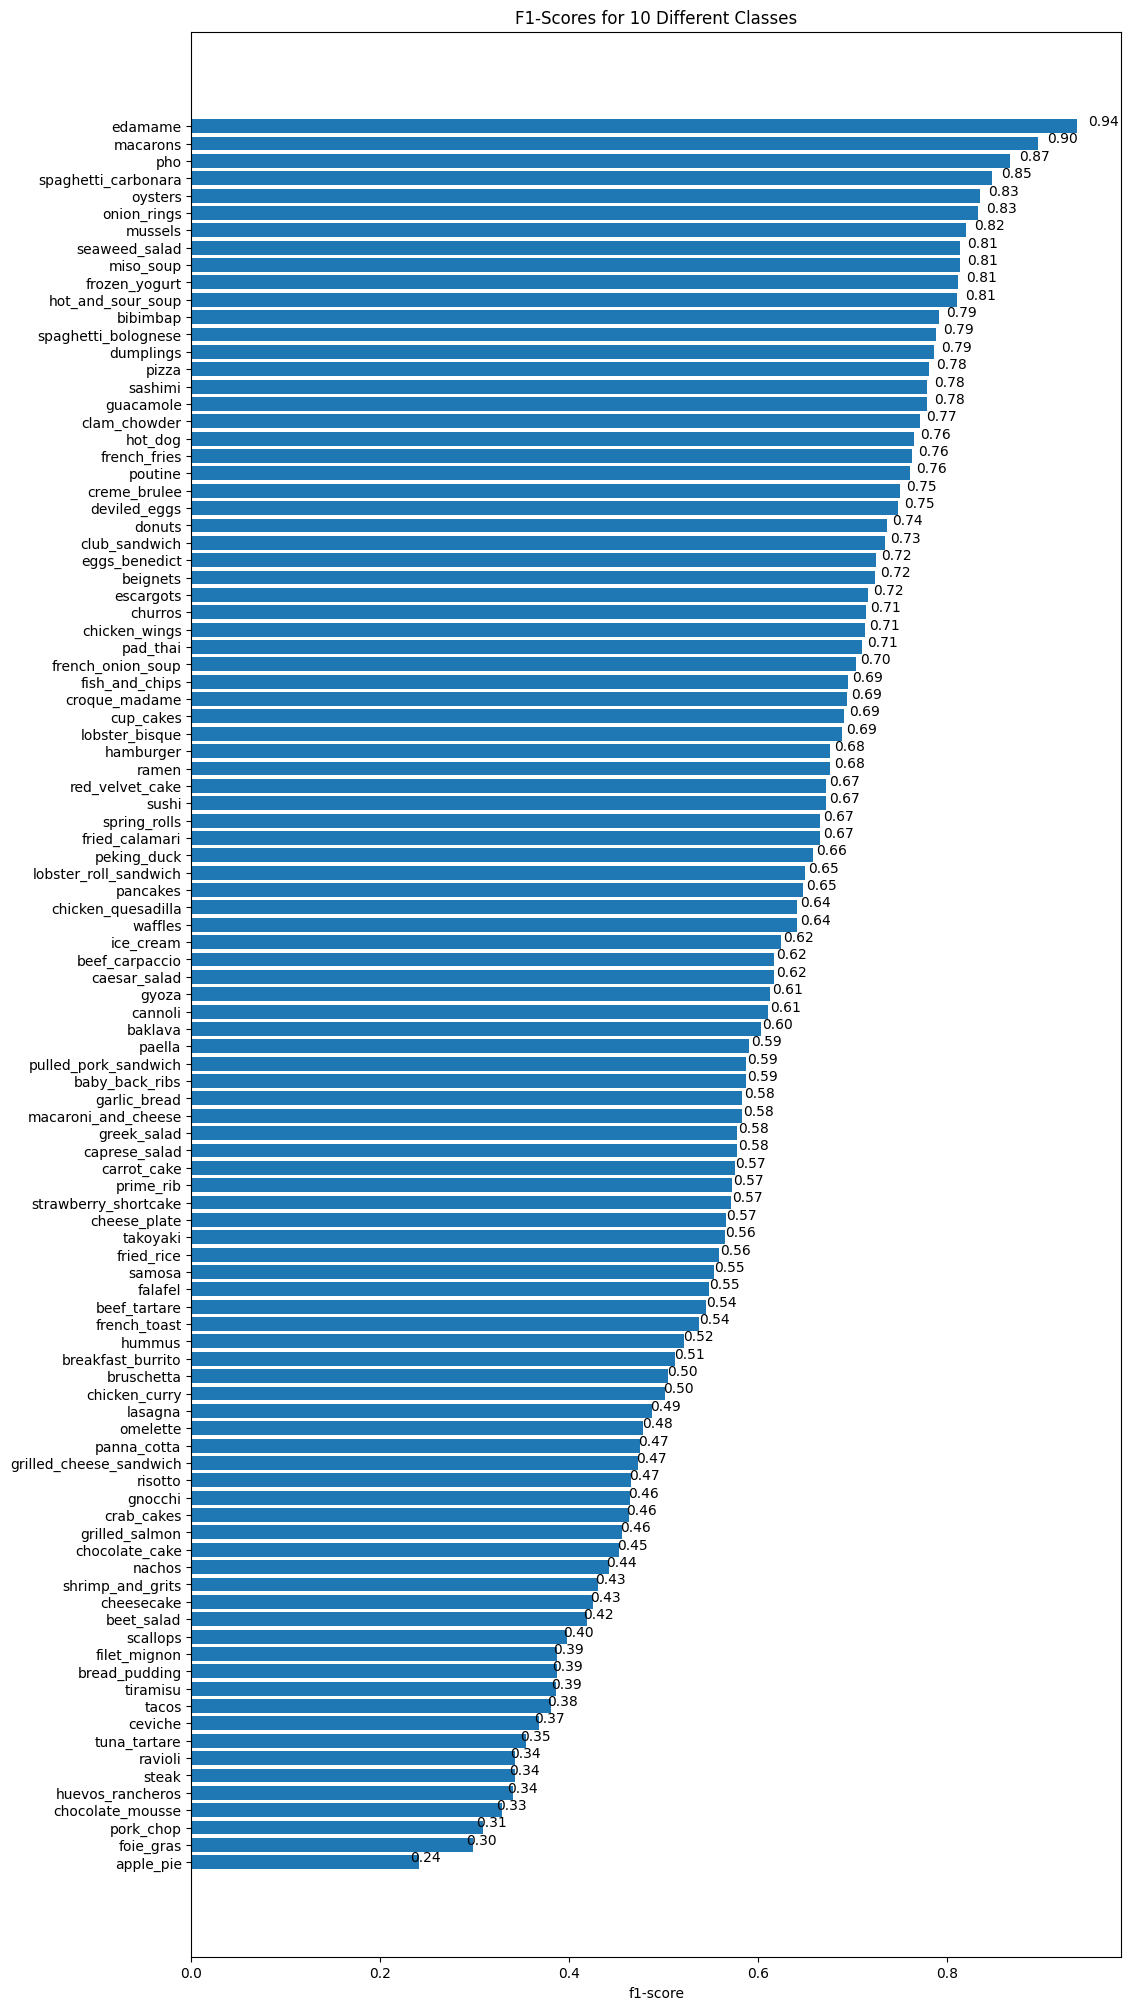

In [48]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)


# Visualizing predictions on test images

Pre-process the images and then predict on it

In [49]:
# Create a function to prepare the images
def load_and_prep_image(filename, image_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes it into specified shape
  (img_shape, img_shape, color_channels=3)

  Args:
    filename (str) : Path to target image
    image_shape (int): Height/Width of the image
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns :
    Image tensor of size (img_shape, img_shape, channel)
  """

  # Read the image
  image = tf.io.read_file(filename)

  # Decode image in to tensor
  img = tf.io.decode_image(image, channels=3)

  # Resize the image
  img = tf.image.resize(img, [image_shape, image_shape])

  # Scale
  if scale:
    # Rescale the image
    return img/255.0
  else:
    return img





1/1 [==============================] - 0s 36ms/step


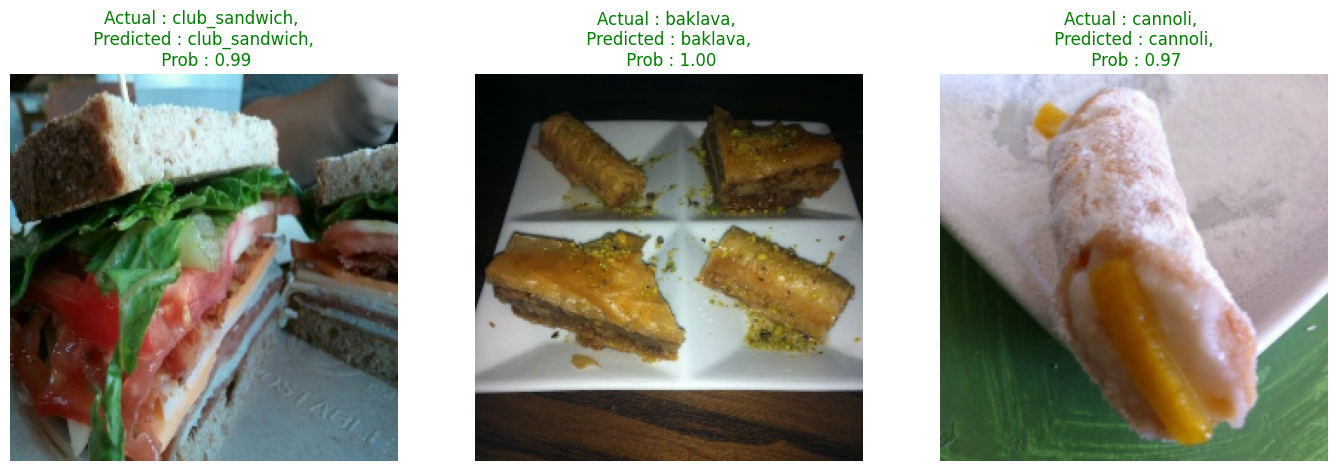

In [67]:
# Make predictions on series of random images
plt.figure(figsize=(17, 15))
for i in range(3):
  # Choose a random image from random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename
  #print(filepath)

  # Load image and make predictions
  img = load_and_prep_image(filepath, scale = False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  #rint(pred_prob)
  #print(pred_class)

  # Plot the images
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.0)
  plt.axis(False)

  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"Actual : {class_name}, \n Predicted : {pred_class}, \n Prob : {pred_prob.max():.2f}", c = title_color)

# Finding the most wrong predictions

In [70]:
# 1. Get all the image file paths in test dataset
filepaths = []

for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepaths.append(filepath.numpy())


In [76]:
# 2. Create a dataframe of different parameters for each of our test image
import pandas as pd
pred_df = pd.DataFrame({"img_path":filepaths,
                       "y_true": y_labels,
                       "y_pred":pred_classes,
                       "pred_conf": preds_prob.max(axis=1),
                       "y_true_classnames": [class_names[i] for i in y_labels],
                       "y_pred_classnames" : [class_names[i] for i in pred_classes]})

pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classnames     y_pred_classnames  
0       0.847418         apple_pie                 gyoza  
1       0.964017         apple_pie             apple_pie  
2       0.959259         apple_pie             apple_pie  
3       0.658607         apple_pie  pulled_pork_sandwich  
4       0.367901         apple_pie             prime_rib  
...          ...               ...                   ...  
25245   0.972823           waffles               waffles  
25246   0.878028           waffles          cheese_plate  
25247   0.537899           waffles               waffles  
25248   0.501950           waffles  strawberry_shortcake  
25249   0.690629           waffles               waffles  

[25250 rows x 6 columns]

In [77]:
#Find out which preds are wrong
pred_df["pred_correct"] = (pred_df["y_true"] == pred_df["y_pred"])
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classnames     y_pred_classnames  pred_correct  
0       0.847418         apple_pie                 gyoza         False  
1       0.964017         apple_pie             apple_pie          True  
2       0.959259         apple_pie             apple_pie          True  
3       0.658607         apple_pie  pulled_pork_sandwich         False  
4       0.367901         apple_pie             prime_rib         False  
...          ...               ...                   ...           ...  
25245   0.972823           waffles               waffles          True  
25246   0.878028           waffles          cheese_plate         False  
25247   0.537899           waffles               waffles          True  
25248   0.501950           waffles  strawberry_shortcake         False  
25249   0.690629           waffles               waffles          True  

[25250 rows x 7 columns]

In [79]:
# 4. sort our df to have most wrong predictions at top
top_100_wrong = pred_df[pred_df['pred_correct'] == False ].sort_values("pred_conf", ascending = False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   
24540  b'/content/101_food_classes_10_percent/test/ti...      98      83   
2511   b'/content/101_food_classes_10_percent/test/br...      10      61   
5574   b'/content/101_food_classes_10_percent/test/ch...      22      21   
17855  b'/content/101_food_classes_10_percent/test/pa...      71      65   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
18001  b'/content/101_food_classes_10_percent/test/pa...      72      67   
11642  b'/content/101_food_classes_10_percent/test/ga...      46      10   
10847  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23631  b'/content/101_food_classes_10_percent/test/st...      94      83   
1155   b'/content/101_food_classes_10_percent/test/be...       4       5   
10854  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23904  b'/content/101_food_classes_10_percent/test/su...      95      86   
7316   b'/content/101_food_classes_10_percent/test/cu...      29      83   
13144  b'/content/101_food_classes_10_percent/test/gy...      52      92   
10880  b'/content/101_food_classes_10_percent/test/fr...      43      68   

       pred_conf      y_true_classnames      y_pred_classnames  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

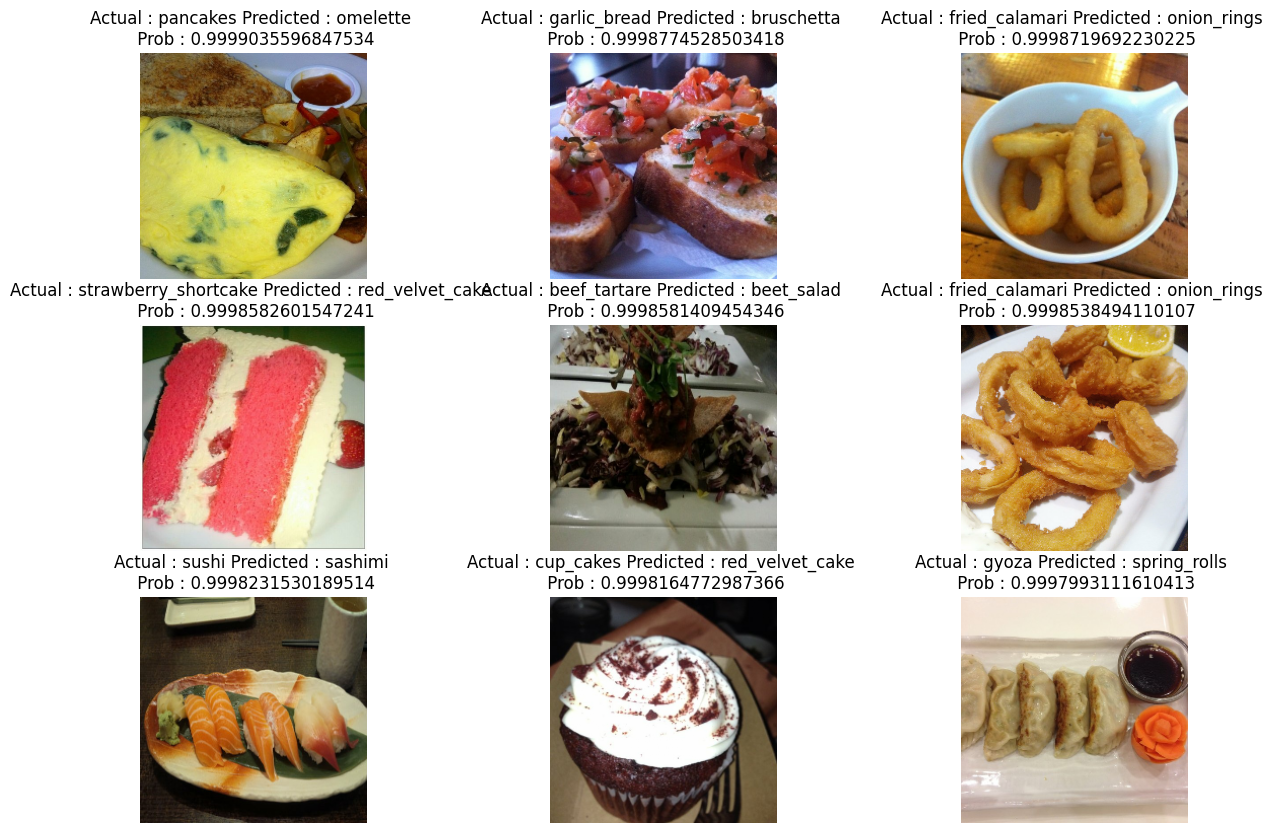

In [90]:
# 5. Visualize some of the images which have highest wrong preds probs
images_to_view = 9
start_index = 10

plt.figure(figsize = (15, 10))
for i, row in enumerate(top_100_wrong[start_index : start_index + images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale = False)
  _,_,_,_, pred_prob, y_true_classname, y_pred_classname, _ = row
  plt.imshow(img/255.0)
  plt.title(f"Actual : {y_true_classname} Predicted : {y_pred_classname} \n Prob : {pred_prob}")
  plt.axis(False)



# Test out the big dog model on test images as well as custom images of food

In [91]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2024-01-23 07:20:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.207, 173.194.74.207, 173.194.192.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2024-01-23 07:20:13 (94.1 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [92]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/sushi.jpeg']

1/1 [==============================] - 0s 78ms/step


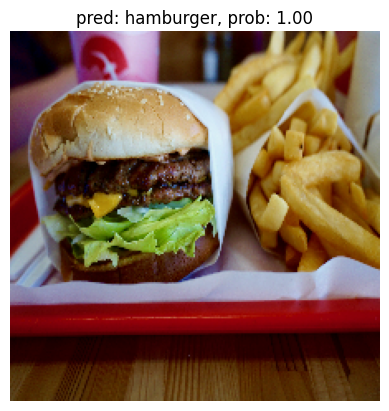

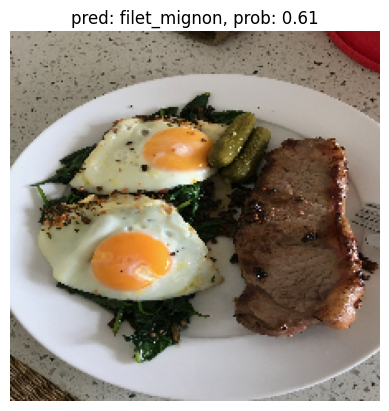

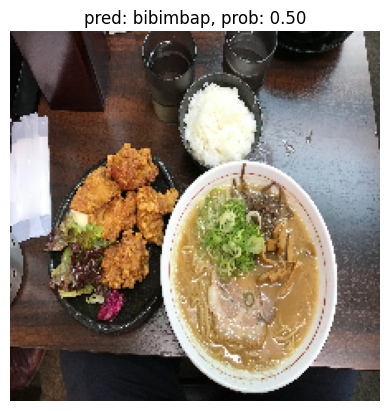

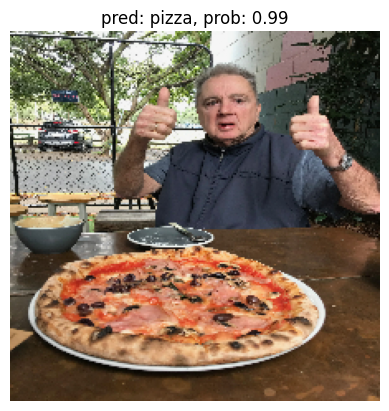

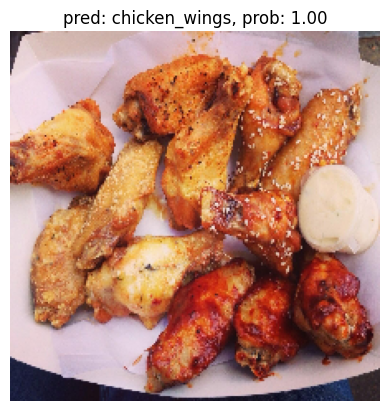

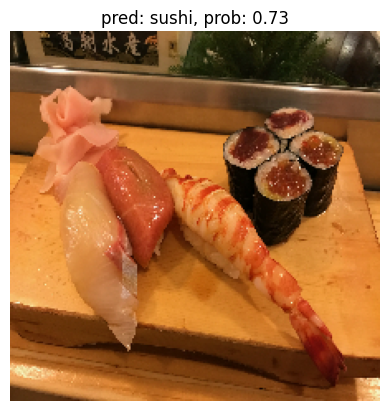

In [93]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

1/1 [==============================] - 0s 51ms/step


(-0.5, 223.5, 223.5, -0.5)

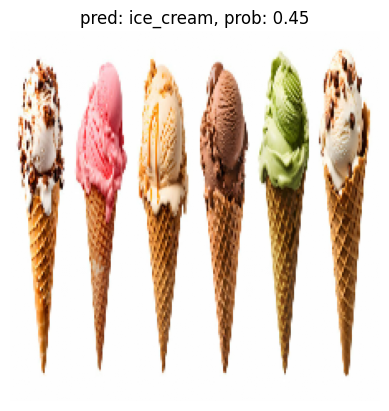

In [94]:
image = "/content/1.jpg"
img = load_and_prep_image(image, scale=False) # load in target image and turn it into tensor
pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
pred_class = class_names[pred_prob.argmax()] # find the predicted class label
# Plot the image with appropriate annotations
plt.figure()
plt.imshow(img/255.) # imshow() requires float inputs to be normalized
plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
plt.axis(False)